In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

# Classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

# Metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

pd.options.display.max_columns = 100

In [2]:
file_path = '../datasets/'
file_hpsa = '03_cleaned_hpsas_filtered.csv'

In [3]:
hpsa = pd.read_csv(file_path + file_hpsa)
hpsa.head(3)

,HPSA Designation Date,HPSA Name,Designation Type,HPSA Score,HPSA Status,HPSA Designation Last Update Date,HPSA Degree of Shortage,Withdrawn Date,HPSA FTE,HPSA Designation Population,% of Population Below 100% Poverty,HPSA Formal Ratio,Primary HHS Region Name,Rural Status,Longitude,Latitude,Common County Name,Common State County FIPS Code,County Equivalent Name,HPSA Component Type Description,HPSA Designation Population Type Description,HPSA Estimated Served Population,HPSA Estimated Underserved Population,HPSA Provider Ratio Goal,HPSA Shortage,State Name,U.S. - Mexico Border 100 Kilometer Indicator,U.S. - Mexico Border County Indicator,Designation,State Population
0,1978-01-23,Warren,Geographic HPSA,0,Withdrawn,1995-10-02,Not applicable,1995-10-02,1.0,83300.0,5.4,0,Region 2,NaN,NaN,NaN,"Warren County, NJ",34041,Warren,Single County,Geographic Population,0.0,0.0,NaN,NaN,New Jersey,N,N,Geographic,8882190.0
1,1978-04-07,Halifax Mental Health Catchment Area,Geographic HPSA,0,Withdrawn,2011-11-03,Not applicable,2011-11-03,3.0,0.0,NaN,0,Region 4,Rural,NaN,NaN,"Halifax County, NC",37083,Halifax,Single County,Geographic Population,0.0,0.0,NaN,0.0,North Carolina,N,N,Geographic,10488084.0
2,1978-04-24,Metropolitan State Hospital,State Mental Hospital,0,Withdrawn,1986-08-19,Not applicable,1986-08-19,22.0,0.0,NaN,0,Region 9,Partially Rural,-119.27023,36.374106,"Tulare County, CA",06107,Tulare,Unknown,State Mental Hospital,0.0,0.0,300:1,0.0,California,U,N,Facility,39512223.0


In [4]:
# Create an indicator for covid-19
hpsa['covid_yr_indicator'] = hpsa['HPSA Designation Date'].map(lambda cell: 'yes' if '2020' in cell else 'no')

In [5]:
hpsa_model = hpsa[['Designation Type','HPSA Status', 'HPSA Score','State Name', 'Rural Status', 'State Population', 
                  'U.S. - Mexico Border County Indicator', 'covid_yr_indicator', 'Designation']].copy()

In [6]:
hpsa_model.isnull().sum()

Designation Type                           0
HPSA Status                                0
HPSA Score                                 0
State Name                                 0
Rural Status                             449
State Population                          99
U.S. - Mexico Border County Indicator      0
covid_yr_indicator                         0
Designation                                0
dtype: int64

In [7]:
hpsa_model.dropna(inplace = True)

In [8]:
hpsa_model = pd.get_dummies(hpsa_model, drop_first=True)

In [11]:
features = hpsa_model.columns

### Baseline Accuracy

In [12]:
hpsa['HPSA Status'].value_counts(normalize=True)

Designated    0.649288
Withdrawn     0.350712
Name: HPSA Status, dtype: float64

### Metrics Function

In [13]:
# This function will calculate the metrics for the classification models
def metrics(model, X_test, y_test):
    y_predictions = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predictions).ravel()
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d');
    
    accuracy = (tp + tn)/ (tp + tn + fp + fn)
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    precision = tp/(tp + fp)
    
    print(f'***Metrics for {model}***')
    print(f'Accuracy = {accuracy}')
    print(f'Sensitivity = {sensitivity}')
    print(f'Specificity = {specificity}')
    print(f'Precision = {precision}')
    
    return 

### Split Data

In [14]:
# Set X and y
X = hpsa_model[features].drop(columns = 'HPSA Status_Withdrawn')
y = hpsa_model['HPSA Status_Withdrawn']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# Modeling

### Logistic Regression 


In [15]:
# Create a pipe object for CountVectorizer and Logistic Regression
logreg_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('logreg', LogisticRegression())
])

In [16]:
# Create a dictionary of the hyperparameters to grid serch in the model
logreg_params = { 
    'logreg__C':[0.5, 1, 1.5],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver':['liblinear']
}

In [17]:
# Create an instance of GridSearch CV
grid_search_logreg = GridSearchCV(logreg_pipe, logreg_params, cv=5) 

In [18]:
grid_search_logreg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.5, 1, 1.5],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear']})

In [19]:
grid_search_logreg.best_score_

0.7848257347428742

In [20]:
grid_search_logreg.best_params_

{'logreg__C': 0.5, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}

In [21]:
grid_search_logreg.score(X_train, y_train)

0.7912304470993965

In [22]:
grid_search_logreg.score(X_test, y_test)

0.7934983376431474

In [23]:
# Use the best parameters to build a logistic regression model
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [24]:
logreg = LogisticRegression(C=0.5, solver='liblinear', penalty='l2')

In [25]:
logreg.fit(Xs_train, y_train)

LogisticRegression(C=0.5, solver='liblinear')

In [26]:
# Review the coefficients for the logistic regression model:
logreg.coef_

array([[-1.21975658e+00,  3.42967872e-02, -1.91687163e-01,
         2.67142547e-01,  1.46962600e-01, -4.21477820e-02,
        -9.00220361e-02,  8.44677962e-03,  4.57710625e-01,
         3.44044446e-01,  4.66043478e-01,  1.35123822e-01,
        -3.42991774e-01, -1.23965644e-01,  1.47302454e-01,
        -4.31965641e-02, -3.50850052e-02, -4.50808604e-02,
        -2.88419877e-02, -1.43885692e-02,  8.46116803e-02,
         1.16677614e-02,  1.09774851e-02, -1.31201474e-01,
        -1.60459865e-01,  3.12176324e-03,  3.57535862e-02,
        -1.53454732e-01,  2.51746343e-01, -1.01840507e-02,
        -9.05820894e-02,  9.86440802e-02,  4.19298211e-02,
         1.59933211e-02, -9.88062820e-02,  2.99992001e-02,
         2.69999197e-02, -3.93844374e-02, -1.06463922e-01,
         1.11428320e-01, -3.81575535e-02, -5.91176438e-02,
         2.06476428e-02,  5.28245624e-02,  3.78450018e-02,
        -5.15233377e-02, -3.06377820e-02,  2.46073630e-02,
        -4.86415628e-02, -7.57967295e-02, -4.10873032e-0

In [27]:
# Transform coefficients
np.exp(logreg.coef_)

array([[0.29530204, 1.0348917 , 0.8255651 , 1.30622663, 1.15831064,
        0.95872809, 0.91391105, 1.00848255, 1.58045159, 1.41064133,
        1.59367629, 1.14467851, 0.70964405, 0.88341019, 1.15870436,
        0.95772312, 0.96552334, 0.95592018, 0.97156997, 0.98571445,
        1.08829438, 1.0117361 , 1.01103796, 0.87704106, 0.85175201,
        1.00312664, 1.03640043, 0.85773959, 1.28626972, 0.98986763,
        0.91339935, 1.10367341, 1.04282129, 1.0161219 , 0.90591818,
        1.03045371, 1.02736772, 0.96138105, 0.89900748, 1.11787361,
        0.96256127, 0.94259587, 1.02086228, 1.05424467, 1.03857024,
        0.94978148, 0.9698268 , 1.02491262, 0.95252249, 0.92700462,
        0.95974534, 0.97525338, 1.01891287, 1.16956463, 0.96088089,
        1.06069211, 0.95707749, 1.07508004, 1.15145451, 0.99898951,
        1.137094  , 1.03769841, 0.9246175 , 1.04049961, 1.02327296,
        1.00746391, 1.04337111, 0.95944487, 0.39628104, 1.06331146,
        0.95872809]])

Interpretation: An increase of 1 in [model_feature] means that an HPSA is [coefficient_number] times as likely to be withdrawn from the designated list

#### Evaluate this Logistic Regression Model

***Metrics for GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.5, 1, 1.5],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear']})***
Accuracy = 0.7934983376431474
Sensitivity = 0.5324232081911263
Specificity = 0.9190371991247265
Precision = 0.7597402597402597


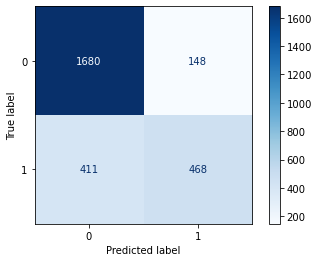

In [28]:
metrics(grid_search_logreg, X_test, y_test)

### Adaboost model

In [29]:
# Reset X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [30]:
pipe_ada_vec = Pipeline([
    ('ss', StandardScaler()),
    ('ada_reg', AdaBoostClassifier())  
])

In [31]:
ada_vec_params = {
    'ada_reg__n_estimators': [50, 75, 100],
}

In [32]:
gs_ada_vec = GridSearchCV(pipe_ada_vec, ada_vec_params, cv=5, verbose=1)

In [33]:
gs_ada_vec.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   12.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('ada_reg', AdaBoostClassifier())]),
             param_grid={'ada_reg__n_estimators': [50, 75, 100]}, verbose=1)

In [34]:
gs_ada_vec.best_score_

0.7936947785679381

In [35]:
gs_ada_vec.best_params_

{'ada_reg__n_estimators': 75}

In [36]:
gs_ada_vec.score(X_train, y_train), gs_ada_vec.score(X_test, y_test)

(0.7992363591575317, 0.7964536387144441)

***Metrics for GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('ada_reg', AdaBoostClassifier())]),
             param_grid={'ada_reg__n_estimators': [50, 75, 100]}, verbose=1)***
Accuracy = 0.7964536387144441
Sensitivity = 0.49715585893060293
Specificity = 0.9403719912472648
Precision = 0.8003663003663004


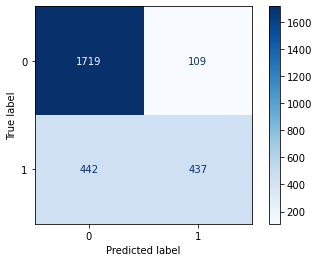

In [37]:
metrics(gs_ada_vec, X_test, y_test)

### Random Forest

In [38]:
# Reset X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [39]:
rf_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

In [40]:
rf_params = {
    'rf__n_estimators': [80, 90, 100],
    'rf__max_depth': [None, 2],
    'rf__max_features': ['auto', None]
}

In [41]:
rf_gs = GridSearchCV(rf_pipe, rf_params, cv=5)

In [42]:
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None, 2],
                         'rf__max_features': ['auto', None],
                         'rf__n_estimators': [80, 90, 100]})

In [43]:
rf_gs.score(X_train, y_train), rf_gs.score(X_test, y_test)

(0.9177238576179333, 0.8367196158108607)

In [44]:
rf_gs.best_score_

0.8358187720240752

In [45]:
rf_gs.best_params_

{'rf__max_depth': None, 'rf__max_features': None, 'rf__n_estimators': 80}

In [46]:
rf_gs.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_features=None, n_estimators=80))])

***Metrics for GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None, 2],
                         'rf__max_features': ['auto', None],
                         'rf__n_estimators': [80, 90, 100]})***
Accuracy = 0.8367196158108607
Sensitivity = 0.714448236632537
Specificity = 0.8955142231947484
Precision = 0.7667887667887668


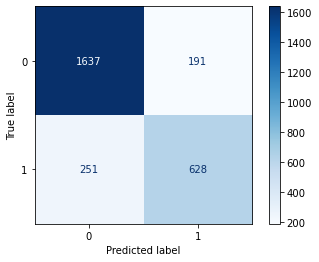

In [47]:
metrics(rf_gs, X_test, y_test)